In [ ]:
# ------------------------------
# STEP 1: Import Required Libraries
# ------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# ------------------------------
# STEP 2: Mount Google Drive
# ------------------------------
from google.colab import drive
drive.mount('/content/drive')

# ------------------------------
# STEP 3: Set Dataset Path
# ------------------------------
dataset_path = "/content/drive/MyDrive/project/Mendeley dataset"

print("Dataset path exists:", os.path.exists(dataset_path))
print("Folders inside dataset:")
print(os.listdir(dataset_path))


Mounted at /content/drive
Dataset path exists: True
Folders inside dataset:
['Negative for Intraepithelial malignancy', 'Squamous cell carcinoma', 'Low squamous intra-epithelial lesion', 'High squamous intra-epithelial lesion']


In [ ]:
import os
import shutil

# ------------------------------
# STEP 4: Create 3-Class Dataset
# ------------------------------

source_path = "/content/drive/MyDrive/project/Mendeley dataset"
target_path = "/content/drive/MyDrive/project/Mendeley_3class"

# Create target folders
classes = ["Normal", "Precancerous", "Malignant"]

for cls in classes:
    os.makedirs(os.path.join(target_path, cls), exist_ok=True)

# Mapping of original classes → new classes
mapping = {
    "Negative for Intraepithelial malignancy": "Normal",
    "Low squamous intra-epithelial lesion": "Precancerous",
    "High squamous intra-epithelial lesion": "Precancerous",
    "Squamous cell carcinoma": "Malignant"
}

# Copy images
for original, new_class in mapping.items():
    src_folder = os.path.join(source_path, original)
    dst_folder = os.path.join(target_path, new_class)

    for img in os.listdir(src_folder):
        shutil.copy(os.path.join(src_folder, img), dst_folder)

print("🎉 3-Class dataset created successfully!")
print("Folder distribution:")
for cls in classes:
    print(cls, "→", len(os.listdir(os.path.join(target_path, cls))), "images")


🎉 3-Class dataset created successfully!
Folder distribution:
Normal → 613 images
Precancerous → 276 images
Malignant → 74 images


In [ ]:
!pip install split-folders

import splitfolders

input_folder = "/content/drive/MyDrive/project/Mendeley_3class"
output_folder = "/content/drive/MyDrive/project/Mendeley_3class_split"

splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.7, 0.15, 0.15)
)

print("✅ Dataset successfully split into Train / Val / Test")


Copying files: 963 files [00:37, 25.67 files/s]

✅ Dataset successfully split into Train / Val / Test


In [ ]:
import os

split_path = "/content/drive/MyDrive/project/Mendeley_3class_split"

for subset in ["train", "val", "test"]:
    print("\n", subset.upper(), "counts:")
    folder = os.path.join(split_path, subset)
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        print(cls, ":", len(os.listdir(cls_path)))



 TRAIN counts:
Normal : 429
Precancerous : 193
Malignant : 51

 VAL counts:
Normal : 91
Precancerous : 41
Malignant : 11

 TEST counts:
Normal : 93
Precancerous : 42
Malignant : 12


In [ ]:
# ----------------------------------------
# STEP 5: Data Preprocessing & Generators
# ----------------------------------------

train_dir = "/content/drive/MyDrive/project/Mendeley_3class_split/train"
val_dir   = "/content/drive/MyDrive/project/Mendeley_3class_split/val"
test_dir  = "/content/drive/MyDrive/project/Mendeley_3class_split/test"

img_size = (224, 224)
batch_size = 32

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Validation/Test should NOT be augmented
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Validation generator
val_gen = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Test generator
test_gen = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print("\nClass mapping:", train_gen.class_indices)


Found 672 images belonging to 3 classes.
Found 143 images belonging to 3 classes.
Found 147 images belonging to 3 classes.

Class mapping: {'Malignant': 0, 'Normal': 1, 'Precancerous': 2}


In [ ]:
# ----------------------------------------
# STEP 6: Build Model 1 - EfficientNetB0
# ----------------------------------------

base1 = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze base model
base1.trainable = False

# Add custom classifier
x1 = GlobalAveragePooling2D()(base1.output)
x1 = Dropout(0.4)(x1)
out1 = Dense(3, activation='softmax')(x1)

model1 = Model(inputs=base1.input, outputs=out1)

model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get labels from train_gen
labels = train_gen.classes

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(4.392156862745098), 1: np.float64(0.5233644859813084), 2: np.float64(1.160621761658031)}


In [ ]:
# ----------------------------------------
# STEP 7: Train EfficientNetB0
# ----------------------------------------

checkpoint_path = "/content/drive/MyDrive/project/efficientnet_model.h5"

checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history1 = model1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint]
)

print("🎉 EfficientNet Training Finished")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1888 - loss: 1.2286
Epoch 1: val_accuracy improved from -inf to 0.63636, saving model to /content/drive/MyDrive/project/efficientnet_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.1954 - loss: 1.2248 - val_accuracy: 0.6364 - val_loss: 0.9985
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4059 - loss: 1.1151
Epoch 2: val_accuracy did not improve from 0.63636
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.4008 - loss: 1.1151 - val_accuracy: 0.2867 - val_loss: 1.1102
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4372 - loss: 1.1293
Epoch 3: val_accuracy did not improve from 0.63636
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.4349 - loss: 1.1292 - val_accuracy: 0.2867 - val_loss: 1.1769
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3119 - loss: 1.1285
Epoch 4: val_accuracy did not improve from 0.63636
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.3101 - loss: 1.1283 - val_accuracy: 0.0769 - val_loss: 1.0959
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4416 - loss: 1.0949
Epoch 5: val_accuracy did not improve from 0.63636
21/

In [ ]:
# ----------------------------------------
# STEP 8: Build Model 2 - MobileNetV2
# ----------------------------------------

base2 = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base2.trainable = False  # freeze base layers

x2 = GlobalAveragePooling2D()(base2.output)
x2 = Dropout(0.4)(x2)
out2 = Dense(3, activation='softmax')(x2)

model2 = Model(inputs=base2.input, outputs=out2)

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ----------------------------------------
# STEP 9: Train MobileNetV2
# ----------------------------------------

checkpoint_path2 = "/content/drive/MyDrive/project/mobilenet_model.h5"

checkpoint2 = keras.callbacks.ModelCheckpoint(
    checkpoint_path2,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history2 = model2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint2]
)

print("🎉 MobileNetV2 Training Finished")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4892 - loss: 1.1146
Epoch 1: val_accuracy improved from -inf to 0.75524, saving model to /content/drive/MyDrive/project/mobilenet_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.4940 - loss: 1.1086 - val_accuracy: 0.7552 - val_loss: 0.6130
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6964 - loss: 0.7555
Epoch 2: val_accuracy improved from 0.75524 to 0.79720, saving model to /content/drive/MyDrive/project/mobilenet_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.6979 - loss: 0.7516 - val_accuracy: 0.7972 - val_loss: 0.4164
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7916 - loss: 0.6360
Epoch 3: val_accuracy improved from 0.79720 to 0.83916, saving model to /content/drive/MyDrive/project/mobilenet_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.7923 - loss: 0.6328 - val_accuracy: 0.8392 - val_loss: 0.3884
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8055 - loss: 0.4477
Epoch 4: val_accuracy did not improve from 0.83916
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8066 - loss: 0.4489 - val_accuracy: 0.8392 - val_loss: 0.3428
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8256 - loss: 0.4580
Epoch 5: val_accuracy improved from 0.83916 to 0.89510, saving model to /content/drive/MyDrive/project/mobilenet_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.8254 - loss: 0.4577 - val_accuracy: 0.8951 - val_loss: 0.2653
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8673 - loss: 0.4143
Epoch 6: val_accuracy did not improve from 0.89510
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8672 - loss: 0.4138 - val_accuracy: 0.8811 - val_loss: 0.2620
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9206 - loss: 0.2876
Epoch 7: val_accuracy did not improve from 0.89510
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9196 - loss: 0.2898 - val_accuracy: 0.8951 - val_loss: 0.2365
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8974 - loss: 0.2883
Epoch 8: val_accuracy did not improve from 0.89510
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8978 - loss: 0.2897 - val_accuracy: 0.8951 - val_loss: 0.2349
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8741 - loss: 0.3161
Epoch 9: val_accuracy improved from 0.89510 to 0.90909,

21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8748 - loss: 0.3156 - val_accuracy: 0.9091 - val_loss: 0.2165
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8880 - loss: 0.3259
Epoch 10: val_accuracy did not improve from 0.90909
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8879 - loss: 0.3260 - val_accuracy: 0.9021 - val_loss: 0.2177
🎉 MobileNetV2 Training Finished


In [ ]:
class_weights

{0: np.float64(4.392156862745098),
 1: np.float64(0.5233644859813084),
 2: np.float64(1.160621761658031)}

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# -------------------------------
# 1. Load your saved model
# -------------------------------
model = load_model("/content/drive/MyDrive/project/mobilenet_model.h5")

# -------------------------------
# 2. Unfreeze top 30 layers
# -------------------------------
for layer in model.layers[-30:]:
    layer.trainable = True

# Freeze BatchNorm layers (important!)
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

print("Trainable layers:", sum([layer.trainable for layer in model.layers]))

# -------------------------------
# 3. Compile with LOWER learning rate
# -------------------------------
model.compile(
    optimizer=Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# -------------------------------
# 4. Add callbacks
# -------------------------------
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/project/mobilenet_finetuned.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# -------------------------------
# 5. Fine-tune training
# -------------------------------
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint, early_stop, reduce_lr],
    class_weight=class_weights
)

Trainable layers: 22
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8931 - loss: 0.3622
Epoch 1: val_accuracy improved from -inf to 0.91608, saving model to /content/drive/MyDrive/project/mobilenet_finetuned.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8938 - loss: 0.3609 - val_accuracy: 0.9161 - val_loss: 0.1847 - learning_rate: 1.0000e-05
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9177 - loss: 0.2715
Epoch 2: val_accuracy did not improve from 0.91608
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.9174 - loss: 0.2717 - val_accuracy: 0.9021 - val_loss: 0.1841 - learning_rate: 1.0000e-05
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9059 - loss: 0.3021
Epoch 3: val_accuracy improved from 0.91608 to 0.95804, saving model to /content/drive/MyDrive/project/mobilenet_finetuned.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9063 - loss: 0.2993 - val_accuracy: 0.9580 - val_loss: 0.1393 - learning_rate: 1.0000e-05
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9046 - loss: 0.2851
Epoch 4: val_accuracy did not improve from 0.95804
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9044 - loss: 0.2846 - val_accuracy: 0.9161 - val_loss: 0.1501 - learning_rate: 1.0000e-05
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9445 - loss: 0.2175
Epoch 5: val_accuracy did not improve from 0.95804
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9439 - loss: 0.2176 - val_accuracy: 0.8951 - val_loss: 0.2094 - learning_rate: 1.0000e-05
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9213 - loss: 0.2609
Epoch 6: val_accuracy did not improve from 0.95804
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9215 - loss: 0.2596 - val_accuracy: 0.9161 - val_loss: 0.1537 - learning_rate: 1.0000e-05
Epoch 7/20
21/21 ━━━━━━━━━

21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9164 - loss: 0.2169 - val_accuracy: 0.9720 - val_loss: 0.1069 - learning_rate: 1.0000e-05
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9472 - loss: 0.1788
Epoch 8: val_accuracy did not improve from 0.97203
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9469 - loss: 0.1793 - val_accuracy: 0.9441 - val_loss: 0.1196 - learning_rate: 1.0000e-05
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9374 - loss: 0.1848
Epoch 9: val_accuracy did not improve from 0.97203
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9376 - loss: 0.1854 - val_accuracy: 0.9161 - val_loss: 0.1465 - learning_rate: 1.0000e-05
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9333 - loss: 0.1811
Epoch 10: val_accuracy did not improve from 0.97203
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9336 - loss: 0.1811 - val_accuracy: 0.9650 - val_loss: 0.0951 - learning_rate: 1.0000e-05
Epoch 11/20
21/21 ━━━━━━

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get true labels
test_labels = test_gen.classes

# Predict
pred_probs = model.predict(test_gen)
pred_labels = np.argmax(pred_probs, axis=1)

# Print report
print(classification_report(test_labels, pred_labels, target_names=list(test_gen.class_indices.keys())))


5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step
              precision    recall  f1-score   support

   Malignant       0.90      0.75      0.82        12
      Normal       0.99      0.99      0.99        93
Precancerous       0.91      0.95      0.93        42

    accuracy                           0.96       147
   macro avg       0.93      0.90      0.91       147
weighted avg       0.96      0.96      0.96       147



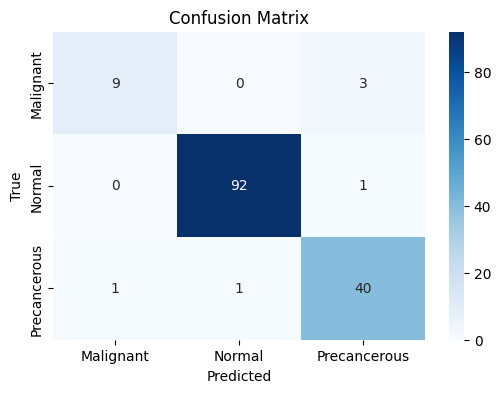

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
cm = confusion_matrix(test_labels, pred_labels)

class_names = list(test_gen.class_indices.keys())
for i, cls in enumerate(class_names):
    acc = cm[i,i] / cm[i].sum()
    print(f"{cls} accuracy: {acc*100:.2f}%")


Malignant accuracy: 75.00%
Normal accuracy: 98.92%
Precancerous accuracy: 95.24%


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------
# 1. Dataset Paths
# --------------------------
test_dir = "/content/drive/MyDrive/project/Mendeley_3class_split/test"
img_size = (224, 224)
batch_size = 16

# --------------------------
# 2. Test Generator
# --------------------------
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(test_generator.class_indices.keys())
print("Class Labels:", class_labels)

# --------------------------
# 3. Load EfficientNetB0 Model
# --------------------------
eff_model = tf.keras.models.load_model("/content/drive/MyDrive/project/efficientnet_model.h5")
print("EfficientNetB0 model loaded!")

# --------------------------
# 4. Predictions
# --------------------------
pred_proba = eff_model.predict(test_generator)
pred_labels = np.argmax(pred_proba, axis=1)
true_labels = test_generator.classes

# --------------------------
# 5. Classification Report
# --------------------------
print("\n📌 Classification Report — EfficientNetB0")
print(classification_report(true_labels, pred_labels, target_names=class_labels))

# --------------------------
# 6. Confusion Matrix
# --------------------------
cm = confusion_matrix(true_labels, pred_labels)
print("\n📌 Confusion Matrix — EfficientNetB0")
print(cm)

# --------------------------
# 7. Per-Class Accuracy
# --------------------------
print("\n📌 Per-Class Accuracy — EfficientNetB0")
for i, cls in enumerate(class_labels):
    correct = cm[i][i]
    total = np.sum(cm[i])
    acc = (correct / total) * 100
    print(f"{cls}: {acc:.2f}%")



Found 147 images belonging to 3 classes.
Class Labels: ['Malignant', 'Normal', 'Precancerous']


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


EfficientNetB0 model loaded!
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step

📌 Classification Report — EfficientNetB0
              precision    recall  f1-score   support

   Malignant       0.00      0.00      0.00        12
      Normal       0.63      1.00      0.78        93
Precancerous       0.00      0.00      0.00        42

    accuracy                           0.63       147
   macro avg       0.21      0.33      0.26       147
weighted avg       0.40      0.63      0.49       147


📌 Confusion Matrix — EfficientNetB0
[[ 0 12  0]
 [ 0 93  0]
 [ 0 42  0]]

📌 Per-Class Accuracy — EfficientNetB0
Malignant: 0.00%
Normal: 100.00%
Precancerous: 0.00%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 147 images belonging to 3 classes.
Classes: ['Malignant', 'Normal', 'Precancerous']


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Both models loaded successfully!
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step
Predictions collected!

📌 ENSEMBLE CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Malignant       0.89      0.67      0.76        12
      Normal       0.99      0.99      0.99        93
Precancerous       0.89      0.95      0.92        42

    accuracy                           0.95       147
   macro avg       0.92      0.87      0.89       147
weighted avg       0.95      0.95      0.95       147


📌 ENSEMBLE CONFUSION MATRIX
 [[ 8  0  4]
 [ 0 92  1]
 [ 1  1 40]]


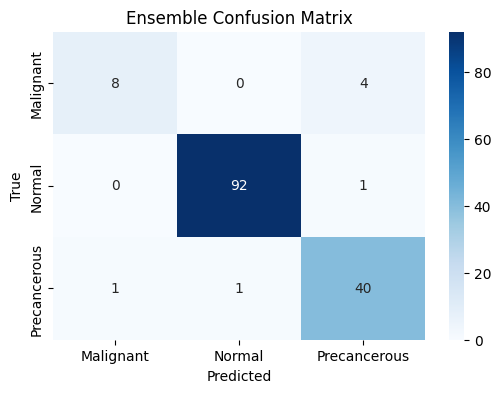


📌 ENSEMBLE PER-CLASS ACCURACY
Malignant: 66.67%
Normal: 98.92%
Precancerous: 95.24%

Ensemble predictions saved!


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------
# 1. Reload test generator
# --------------------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = "/content/drive/MyDrive/project/Mendeley_3class_split/test"
img_size = (224, 224)
batch_size = 16

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(test_gen.class_indices.keys())
print("Classes:", class_labels)


# --------------------------------------
# 2. Load both models
# --------------------------------------
eff_model = tf.keras.models.load_model("/content/drive/MyDrive/project/efficientnet_model.h5")
mobile_model = tf.keras.models.load_model("/content/drive/MyDrive/project/mobilenet_finetuned.h5")

print("Both models loaded successfully!")


# --------------------------------------
# 3. Predict probabilities from each model
# --------------------------------------
eff_pred = eff_model.predict(test_gen)
mobile_pred = mobile_model.predict(test_gen)

print("Predictions collected!")


# --------------------------------------
# 4. Soft Voting Ensemble
# --------------------------------------
final_prob = (eff_pred + mobile_pred) / 2
final_pred = np.argmax(final_prob, axis=1)

true_labels = test_gen.classes


# --------------------------------------
# 5. Classification Report
# --------------------------------------
print("\n📌 ENSEMBLE CLASSIFICATION REPORT")
print(classification_report(true_labels, final_pred, target_names=class_labels))


# --------------------------------------
# 6. Confusion Matrix
# --------------------------------------
cm = confusion_matrix(true_labels, final_pred)
print("\n📌 ENSEMBLE CONFUSION MATRIX\n", cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Ensemble Confusion Matrix")
plt.show()


# --------------------------------------
# 7. Per-Class Accuracy
# --------------------------------------
print("\n📌 ENSEMBLE PER-CLASS ACCURACY")
for i, cls in enumerate(class_labels):
    acc = cm[i][i] / cm[i].sum()
    print(f"{cls}: {acc*100:.2f}%")

# --------------------------------------
# 8. Save ensemble predictions (optional)
# --------------------------------------
np.save("/content/drive/MyDrive/project/ensemble_predictions.npy", final_prob)
print("\nEnsemble predictions saved!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

FINAL ENSEMBLE PREDICTION
Predicted Class: Precancerous

Confidence Scores:
Malignant: 13.78%
Normal: 20.25%
Precancerous: 65.97%


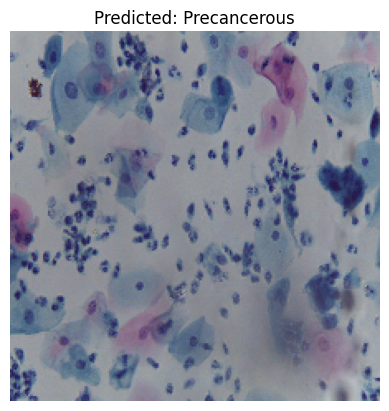

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# ----------------------------
# Load your models
# ----------------------------
eff_model = tf.keras.models.load_model("/content/drive/MyDrive/project/efficientnet_model.h5")
mobile_model = tf.keras.models.load_model("/content/drive/MyDrive/project/mobilenet_finetuned.h5")

# Class labels
class_labels = ['Malignant', 'Normal', 'Precancerous']


# ----------------------------
# Preprocess function
# ----------------------------
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array


# ----------------------------
# Predict function
# ----------------------------
def predict_image(img_path):

    img, img_array = preprocess_image(img_path)

    # Predictions from each model
    eff_pred = eff_model.predict(img_array)
    mobile_pred = mobile_model.predict(img_array)

    # Soft voting
    final_prob = (eff_pred + mobile_pred) / 2
    final_class = np.argmax(final_prob)

    # Print result
    print("\n==============================")
    print("FINAL ENSEMBLE PREDICTION")
    print("==============================")
    print(f"Predicted Class: {class_labels[final_class]}")
    print("\nConfidence Scores:")
    for i, cls in enumerate(class_labels):
        print(f"{cls}: {final_prob[0][i] * 100:.2f}%")

    # Display image
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_labels[final_class]}")
    plt.show()


# ----------------------------
# PREDICT YOUR IMAGE
# ----------------------------
predict_image("/content/precancer.jpg")


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input

# Load both trained models
eff_model = tf.keras.models.load_model("/content/drive/MyDrive/project/efficientnet_model.h5")
mobile_model = tf.keras.models.load_model("/content/drive/MyDrive/project/mobilenet_finetuned.h5")

# Freeze them so they don't train (important for deployment)
eff_model.trainable = False
mobile_model.trainable = False

# Input layer
input_layer = Input(shape=(224, 224, 3))

# Get outputs from both models
eff_output = eff_model(input_layer)
mobile_output = mobile_model(input_layer)

# Soft voting (average)
ensemble_output = tf.keras.layers.Average()([eff_output, mobile_output])

# Create final ensemble model
ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)

ensemble_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 3)         │  4,053,414 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 3)         │  2,261,827 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, 3)         │          0 │ functional[0][0], │
│                     │                   │            │ functional_1[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,315,241 (24.09 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,315,241 (24.09 MB)

In [ ]:
ensemble_model.save("/content/drive/MyDrive/project/ensemble_model.keras")
print("🎉 Ensemble model saved successfully!")

🎉 Ensemble model saved successfully!
